In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300

## True forecast covariance

In [2]:
N = 100
d1 = 1
d2 = 8
Pt = np.eye(N)
for i in range(N):
    for j in range(N):
        Pt[i,j] = np.sqrt(i*j/N/N)*np.exp(-0.5*((i-j)/d1)**2) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*np.exp(-0.5*((i-j)/d2)**2) 

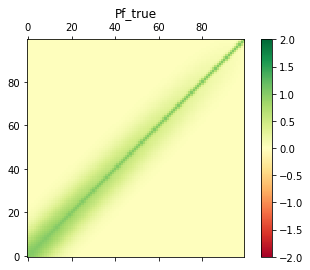

In [3]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
cmap = 'RdYlGn'
fig, ax = plt.subplots()
mappable = ax.matshow(Pt, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title('Pf_true')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig('Pf_true.pdf')
plt.show()

In [4]:
from scipy.linalg import eigh, norm
eigs, eigv = eigh(Pt)
sPt = eigv @ np.diag(np.sqrt(eigs))
print(sPt.shape)
print(norm(Pt - sPt@sPt.transpose()))

(100, 100)
6.341124912457197e-14


## localization matrix

In [5]:
d1 = 1*3.0
d2 = 8*3.0
Ftilde = np.eye(N)
for i in range(N):
    for j in range(N):
        Ftilde[i,j] = np.sqrt(i*j/N/N)*np.exp(-0.5*((i-j)/d1)**2) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*np.exp(-0.5*((i-j)/d2)**2) 
eigs, eigv = eigh(Ftilde)
neig = 1
thres = 0.85
frac = 0.0
while frac < thres:
    frac = eigs[N-neig:N].sum() / eigs.sum()
    neig += 1
print(neig)
Wtilde = eigv[:,N-neig:N] @ np.diag(np.sqrt(eigs[N-neig:N]))
Flow = Wtilde @ Wtilde.transpose()

11


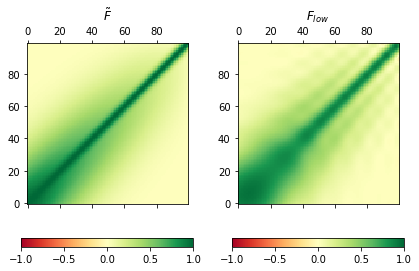

In [6]:
fig, ax = plt.subplots(1,2)
mappable = ax[0].matshow(Ftilde, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[0].invert_yaxis()
ax[0].set_title(r'$\tilde{F}$')
fig.colorbar(mappable, ax=ax[0], orientation='horizontal')
mappable = ax[1].matshow(Flow, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[1].invert_yaxis()
ax[1].set_title(r'$F_{low}$')
fig.colorbar(mappable, ax=ax[1], orientation='horizontal')
fig.tight_layout()
plt.show()

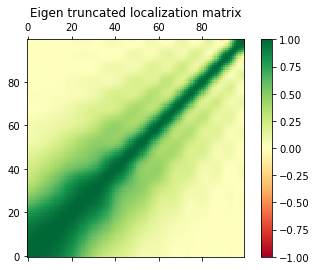

In [7]:
W = Wtilde
diagF = np.diag(Flow)
for i in range(W.shape[0]):
    W[i, :] /= np.sqrt(diagF[i])
F = W @ W.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(F, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax.invert_yaxis()
ax.set_title(f'Eigen truncated localization matrix')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'locmat.pdf')
plt.show()

In [8]:
def calc_dist(i):
    d1 = 1
    d2 = 8
    dist = np.zeros(N)
    for j in range(N):
        dist[j] = np.sqrt(i*j/N/N)*(np.fabs(i-j)/d1) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*(np.fabs(i-j)/d2) 
    return dist

def calc_dist1(i,j):
    d1 = 1
    d2 = 8
    dist = np.sqrt(i*j/N/N)*(np.fabs(i-j)/d1) + np.sqrt((1.0-float(i)/N)*(1.0-float(j)/N))*(np.fabs(i-j)/d2) 
    return dist

## Observation operator and error covariance

In [9]:
class Obs():
    def __init__(self, operator, sigma,Pt):
        self.operator=operator
        self.sigma=sigma
        self.Pt = Pt
        logger.info(f"operator={self.operator}, sigma={self.sigma}")
    
    def get_op(self):
        return self.operator
    
    def get_sig(self):
        return self.sigma
        
    def set_r(self, N):
        from scipy.linalg import inv
        oberrstdev = self.sigma
        oberrvar = oberrstdev**2
        H = self.dh_operator(np.arange(N), np.zeros(N))
        HPHt = H @ self.Pt @ H.transpose()
        R = oberrvar * np.diag(np.diag(HPHt))
        Rsqrt = oberrstdev * np.diag(np.sqrt(np.diag(HPHt)))
        Rsqrtinv = inv(Rsqrt)
        Rinv = Rsqrtinv.transpose() @ Rsqrtinv
        return R, Rsqrtinv, Rinv
    
    def dh_operator(self, obsloc, x):
        p = obsloc.size
        n = x.size
        H = np.zeros((p,n))
        logger.debug(f"H={H.shape}")
        smooth_len = 4.0
        for j in range(p):
            for i in range(n):
                rr = float(i)-obsloc[j]
                r = np.fabs(rr) / smooth_len
                H[j,i] = np.exp(-r**2)
            H[j,:] = H[j,:]/H[j,:].sum()
        return H
    
    def h_operator(self,obsloc,x):
        if x.ndim > 1:
            hx = self.dh_operator(obsloc,x[:,0]) @ x
        else:
            hx = self.dh_operator(obsloc,x) @ x
        logger.debug(f"hx={hx.shape}")
        return hx

In [10]:
import logging
from logging.config import fileConfig
fileConfig('logging_config.ini')
logger = logging.getLogger('anl')
oberrstdev = 1.0 / 8.0
obs = Obs('vint', oberrstdev,Pt)

2021-09-07 08:20:24,488 anl INFO operator=vint, sigma=0.125


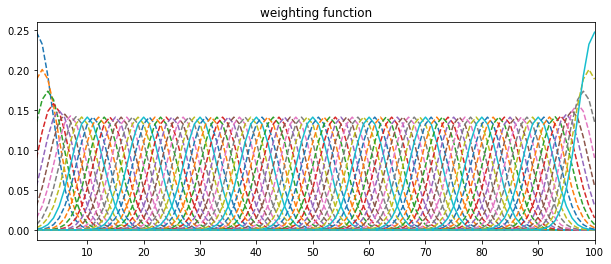

In [11]:
p = N #observed all grid
H = obs.dh_operator(np.arange(p), np.zeros(N))
vindex = np.arange(1,p+1)
fig, ax = plt.subplots(figsize=(10,4))
for j in range(p):
    if np.mod(j+1,10) == 0:
        linestyle='solid'
    else:
        linestyle='dashed'
    ax.plot(vindex,H[j], linestyle=linestyle)
ax.set_xlim(vindex[0],vindex[-1])
ax.set_xticks(vindex[9::10])
ax.set_title('weighting function')
#fig.savefig('Hrow.pdf')
plt.show()

(100, 100) (100, 100) (100, 100)
1.6063764188150566e-17
0.0


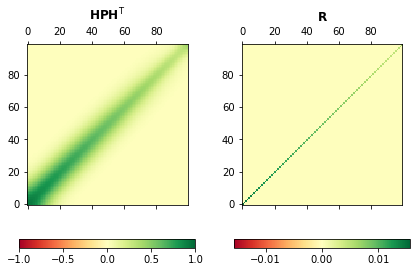

In [12]:
from scipy.linalg import inv
H = obs.dh_operator(np.arange(N), np.zeros(N))
oberrvar = obs.get_sig()**2
HPHt = H @ Pt @ H.transpose()
R, Rsqrtinv, Rinv = obs.set_r(N)
print(R.shape, Rsqrtinv.shape, Rinv.shape)
Rsqrt = inv(Rsqrtinv)
print(norm(R - Rsqrt@Rsqrt))
print(norm(Rinv - Rsqrtinv@Rsqrtinv))
fig, ax = plt.subplots(1,2)
mappable = ax[0].matshow(HPHt, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax[0].invert_yaxis()
ax[0].set_title(r"$\mathbf{H}\mathbf{P}\mathbf{H}^\mathrm{T}$")
fig.colorbar(mappable, ax=ax[0], orientation='horizontal')
mappable = ax[1].matshow(R, cmap=cmap, norm=Normalize(vmin=-oberrvar, vmax=oberrvar))
ax[1].invert_yaxis()
ax[1].set_title(r"$\mathbf{R}$")
fig.colorbar(mappable, ax=ax[1], orientation='horizontal')
fig.tight_layout()
plt.show()

## Varidation

In [13]:
def mse(Pa_app):
    diff = np.zeros_like(Pa_app)
    for j in range(N):
        for i in range(N):
            diff[j,i] = (Pa_app[j,i] - Pat[j,i])**2
    diff = F * diff
    mse = diff.sum()
    mse /= N**2
    return mse

def corr(Pa_app):
    tmp = Pa_app**2
    var1 = tmp.sum()
    tmp = Pat**2
    var2 = tmp.sum()
    tmp = Pa_app * Pat
    cov = tmp.sum()
    corr = cov / np.sqrt(var1) / np.sqrt(var2)
    return corr

## Lists for storing results and counter

In [14]:
xrmse_mean = []
mse_mean = []
corr_mean = []
ntest = 0

### Test

## Random seed

In [158]:
rs = np.random.RandomState() #variable
rstrue = np.random.RandomState(514) #fix

## True state and observation

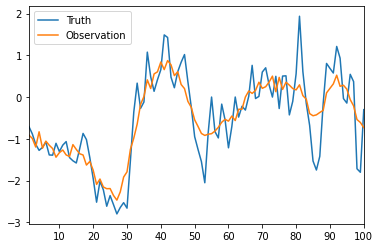

In [159]:
xt = sPt @ rstrue.standard_normal(size=N)
y = obs.dh_operator(np.arange(p), xt) @ xt + Rsqrt @ rs.standard_normal(size=p)
plt.plot(vindex, xt, label='Truth')
plt.plot(vindex, y, label='Observation')
plt.xticks(vindex[9::10])
plt.xlim(vindex[0],vindex[-1])
plt.legend()
#plt.savefig('true_obs.pdf')
plt.show()

## Forecast ensemble

In [160]:
K = 50
Xf = rs.standard_normal(size=(N,K))
Xf = sPt @ Xf
Xf = Xf - Xf.mean(axis=1)[:, None]
Pe = Xf @ Xf.transpose() / (K-1)
err = norm(Pt - Pe)
print(err)

14.443601758964002


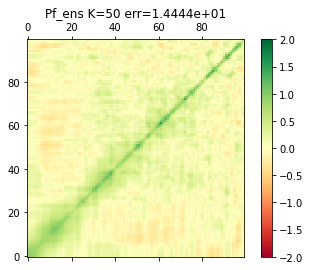

In [161]:
fig, ax = plt.subplots()
mappable = ax.matshow(Pe, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'Pf_ens K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_ens_{K}.pdf')
plt.show()

7.9292974873811675


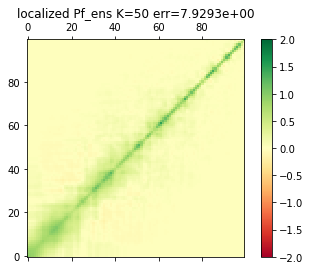

In [162]:
Ploc = Pe * F
err = norm(Pt - Ploc)
print(err)

fig, ax = plt.subplots()
mappable = ax.matshow(Ploc, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'localized Pf_ens K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_locens_{K}.pdf')
plt.show()

(100, 50)
1.570855131884976


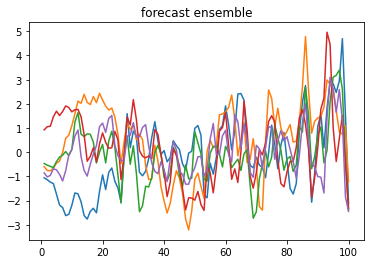

In [163]:
# forecast ensemble
## mean
xf_ = sPt @ rs.standard_normal(size=N)
## member
xf = xf_[:, None] + Xf
print(xf.shape)
initial_mean_err = np.sqrt(((xf.mean(axis=1) - xt)**2).mean())
print(initial_mean_err)
for k in range(0,K,10):
    plt.plot(vindex, xf[:,k])
plt.title('forecast ensemble')
plt.show()

Nmode=68
7.93423746100958


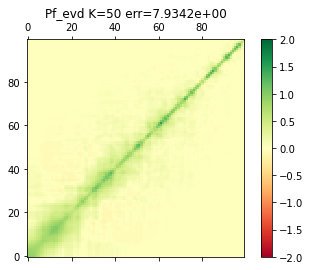

In [164]:
# eigen value decomposition
eigs, eigv = eigh(Ploc)
eigs = eigs[::-1]
eigv = eigv[:,::-1]
M = 1
thres = 0.99
frac = 0.0
esum = eigs.sum()
while frac < thres:
    frac = eigs[:M].sum() /  esum
    M += 1
M = min(M, N)
print(f"Nmode={M}")
Xfm = np.empty((N, M), Xf.dtype)
Xfm = eigv[:,:M] @ np.diag(np.sqrt(eigs[:M])) * np.sqrt(M-1)
Pmod = Xfm @ Xfm.transpose() / (M-1)
err = norm(Pt - Pmod)
print(err)

fig, ax = plt.subplots()
mappable = ax.matshow(Pmod, cmap=cmap, norm=Normalize(vmin=-2., vmax=2.))
ax.invert_yaxis()
ax.set_title(f'Pf_evd K={K} err={err:.4e}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'Pf_evd_{K}.pdf')
plt.show()

In [165]:
# compute true analysis error covariance for modulated ensemble
Htilde = Rsqrtinv @ obs.dh_operator(np.arange(p), xf_)
Z = Xfm / np.sqrt(M-1)
HZ = Htilde @ Z
A = HZ.transpose() @ HZ
eigs, eigv = eigh(A)
Dsqrt = np.sqrt(1.0/(1.0+eigs))
T = eigv @ np.diag(Dsqrt) @ eigv.transpose()
Za = Z @ T
Kmat = Za @ Za.transpose() @ Htilde.transpose()

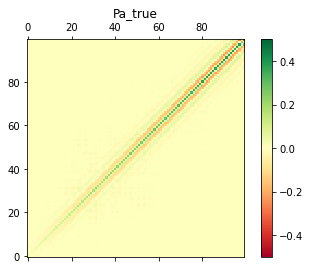

In [166]:
KHP = Kmat @ Htilde @ Pt
Pat = Pt - KHP - KHP.transpose() + Kmat@(Htilde@Pt@Htilde.transpose()+np.eye(p))@Kmat.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(Pat, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
ax.invert_yaxis()
ax.set_title('Pa_true')
fig.colorbar(mappable, ax=ax, orientation='vertical')
if ntest == 0:
    fig.savefig('Pa_true_evd.pdf')
plt.show()

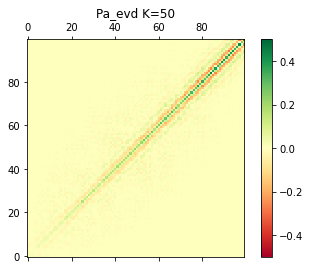

In [167]:
Pam = Za @ Za.transpose()
fig, ax = plt.subplots()
mappable = ax.matshow(Pam, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
ax.invert_yaxis()
ax.set_title(f'Pa_evd K={K}')
fig.colorbar(mappable, ax=ax, orientation='vertical')
if ntest == 0:
    fig.savefig(f'Pa_evd_{K}.pdf')
plt.show()

## EnKF

2021-09-07 08:27:27,525 anl INFO model : model
2021-09-07 08:27:27,526 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 08:27:27,527 anl INFO linf=False iloc=1 ltlm=False
2021-09-07 08:27:27,593 anl INFO set R
2021-09-07 08:27:27,653 anl INFO pf max=1.4931659652521567 min=-0.4045801850604836
2021-09-07 08:27:27,654 anl INFO ==B-localization==, lsig=3.0
2021-09-07 08:27:27,656 anl INFO lpf max=1.4931659652521565 min=-0.15354833597174228
2021-09-07 08:27:27,660 anl INFO pf eigen value = [1.13749085e+01 9.75297419e+00 6.50125970e+00 5.46919561e+00
 5.01745622e+00 4.09593837e+00 3.61198412e+00 3.52004297e+00
 3.06311837e+00 2.72169896e+00 2.55923868e+00 2.28735306e+00
 1.95755710e+00 1.93981179e+00 1.67958119e+00 1.56005529e+00
 1.46182032e+00 1.42148875e+00 1.38392015e+00 1.31143831e+00
 1.23249216e+00 1.14868031e+00 1.10803527e+00 1.09135849e+00
 1.00097089e+00 9.70888500e-01 9.23026568e-01 8.52361483e-01
 7.98712470e-01 7.30866972e-01 6.91233560e-01 6.68849113e-01
 6

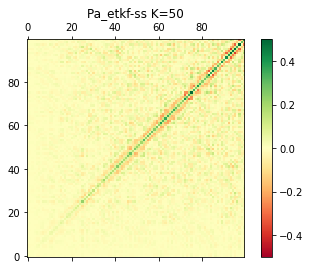

2021-09-07 08:27:28,450 anl INFO model : model
2021-09-07 08:27:28,451 anl INFO pt=etkf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 08:27:28,451 anl INFO linf=False iloc=1 ltlm=False
2021-09-07 08:27:28,518 anl INFO set R
2021-09-07 08:27:28,579 anl INFO pf max=1.4931659652521567 min=-0.4045801850604836
2021-09-07 08:27:28,580 anl INFO ==B-localization==, lsig=3.0
2021-09-07 08:27:28,581 anl INFO lpf max=1.4931659652521565 min=-0.15354833597174228
2021-09-07 08:27:28,584 anl INFO pf eigen value = [1.13749085e+01 9.75297419e+00 6.50125970e+00 5.46919561e+00
 5.01745622e+00 4.09593837e+00 3.61198412e+00 3.52004297e+00
 3.06311837e+00 2.72169896e+00 2.55923868e+00 2.28735306e+00
 1.95755710e+00 1.93981179e+00 1.67958119e+00 1.56005529e+00
 1.46182032e+00 1.42148875e+00 1.38392015e+00 1.31143831e+00
 1.23249216e+00 1.14868031e+00 1.10803527e+00 1.09135849e+00
 1.00097089e+00 9.70888500e-01 9.23026568e-01 8.52361483e-01
 7.98712470e-01 7.30866972e-01 6.91233560e-01 6.68849113e-01
 6

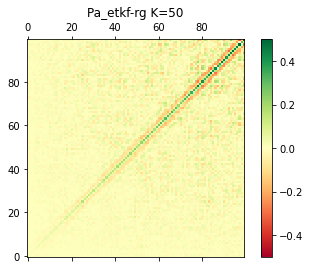

2021-09-07 08:27:29,496 anl INFO model : model
2021-09-07 08:27:29,497 anl INFO pt=po op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 08:27:29,497 anl INFO linf=False iloc=1 ltlm=False
2021-09-07 08:27:29,570 anl INFO set R
2021-09-07 08:27:29,633 anl INFO pf max=1.4931659652521567 min=-0.4045801850604836
2021-09-07 08:27:29,634 anl INFO ==B-localization==, lsig=3.0
2021-09-07 08:27:29,636 anl INFO lpf max=1.4931659652521565 min=-0.15354833597174228
2021-09-07 08:27:29,641 anl INFO pf eigen value = [1.13749085e+01 9.75297419e+00 6.50125970e+00 5.46919561e+00
 5.01745622e+00 4.09593837e+00 3.61198412e+00 3.52004297e+00
 3.06311837e+00 2.72169896e+00 2.55923868e+00 2.28735306e+00
 1.95755710e+00 1.93981179e+00 1.67958119e+00 1.56005529e+00
 1.46182032e+00 1.42148875e+00 1.38392015e+00 1.31143831e+00
 1.23249216e+00 1.14868031e+00 1.10803527e+00 1.09135849e+00
 1.00097089e+00 9.70888500e-01 9.23026568e-01 8.52361483e-01
 7.98712470e-01 7.30866972e-01 6.91233560e-01 6.68849113e-01
 6.5

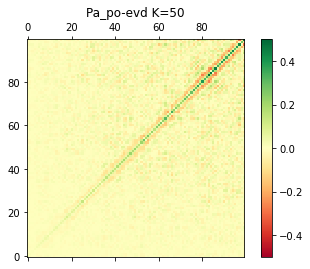

2021-09-07 08:27:30,437 anl INFO model : model
2021-09-07 08:27:30,438 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 08:27:30,438 anl INFO linf=False iloc=1 ltlm=False
2021-09-07 08:27:30,503 anl INFO set R
2021-09-07 08:27:30,566 anl INFO pf max=1.4931659652521567 min=-0.4045801850604836
2021-09-07 08:27:30,567 anl INFO ==B-localization==, lsig=3.0
2021-09-07 08:27:30,568 anl INFO lpf max=1.4931659652521565 min=-0.15354833597174228
2021-09-07 08:27:30,572 anl INFO pf eigen value = [1.13749085e+01 9.75297419e+00 6.50125970e+00 5.46919561e+00
 5.01745622e+00 4.09593837e+00 3.61198412e+00 3.52004297e+00
 3.06311837e+00 2.72169896e+00 2.55923868e+00 2.28735306e+00
 1.95755710e+00 1.93981179e+00 1.67958119e+00 1.56005529e+00
 1.46182032e+00 1.42148875e+00 1.38392015e+00 1.31143831e+00
 1.23249216e+00 1.14868031e+00 1.10803527e+00 1.09135849e+00
 1.00097089e+00 9.70888500e-01 9.23026568e-01 8.52361483e-01
 7.98712470e-01 7.30866972e-01 6.91233560e-01 6.68849113e-01
 6.

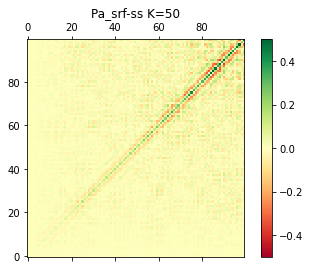

2021-09-07 08:27:31,627 anl INFO model : model
2021-09-07 08:27:31,628 anl INFO pt=srf op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 08:27:31,628 anl INFO linf=False iloc=1 ltlm=False
2021-09-07 08:27:31,689 anl INFO set R
2021-09-07 08:27:31,748 anl INFO pf max=1.4931659652521567 min=-0.4045801850604836
2021-09-07 08:27:31,749 anl INFO ==B-localization==, lsig=3.0
2021-09-07 08:27:31,750 anl INFO lpf max=1.4931659652521565 min=-0.15354833597174228
2021-09-07 08:27:31,754 anl INFO pf eigen value = [1.13749085e+01 9.75297419e+00 6.50125970e+00 5.46919561e+00
 5.01745622e+00 4.09593837e+00 3.61198412e+00 3.52004297e+00
 3.06311837e+00 2.72169896e+00 2.55923868e+00 2.28735306e+00
 1.95755710e+00 1.93981179e+00 1.67958119e+00 1.56005529e+00
 1.46182032e+00 1.42148875e+00 1.38392015e+00 1.31143831e+00
 1.23249216e+00 1.14868031e+00 1.10803527e+00 1.09135849e+00
 1.00097089e+00 9.70888500e-01 9.23026568e-01 8.52361483e-01
 7.98712470e-01 7.30866972e-01 6.91233560e-01 6.68849113e-01
 6.

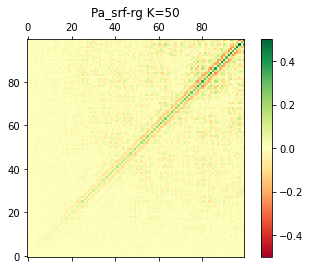

In [168]:
params = {'etkf-ss':('etkf',1,True,False),'etkf-rg':('etkf',1,False,True),'po-evd':('po',1,False,False),
          'srf-ss':('srf',1,True,False),'srf-rg':('srf',1,False,True)}
names = ['evd','etkf-ss','etkf-rg','po-evd','srf-ss','srf-rg']
#names = ['mod','srf','srf-ss','srf-kloc']
xa_list = []
Pa_app_list = [Pam]
from analysis.enkf import EnKF
for ptype in names[1:]:
    pt, iloc, ss, getkf = params[ptype]
    analysis = EnKF(pt, N, K, obs, iloc=iloc, lsig=3.0, ss=ss, getkf=getkf, l_mat=F, l_sqrt=W, calc_dist=calc_dist, calc_dist1=calc_dist1)
    xb = xf
    pb = Pe
    xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y[::-1], np.arange(p-1,-1,-1))
    #xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y, np.arange(p))
    xa_list.append(xa.mean(axis=1))
    Pa_app_list.append(Pa)
    fig, ax = plt.subplots()
    mappable = ax.matshow(Pa, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
    ax.invert_yaxis()
    ax.set_title(f'Pa_{ptype} K={K}')
    fig.colorbar(mappable, ax=ax, orientation='vertical')
    if ntest == 0:
        fig.savefig(f'Paevd_{ptype}_{K}.pdf')
    plt.show()

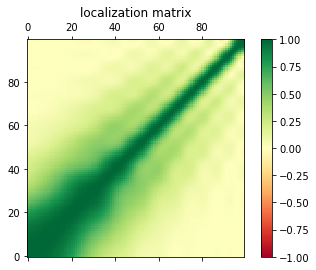

In [169]:
lmat = np.load('model_rho_vint_etkf.npy')
fig, ax = plt.subplots()
mappable = ax.matshow(lmat, cmap=cmap, norm=Normalize(vmin=-1., vmax=1.))
ax.invert_yaxis()
ax.set_title(f'localization matrix')
fig.colorbar(mappable, ax=ax, orientation='vertical')
#fig.savefig(f'locmat.pdf')
plt.show()

### MLEF

(100, 51)
1.679774714641414


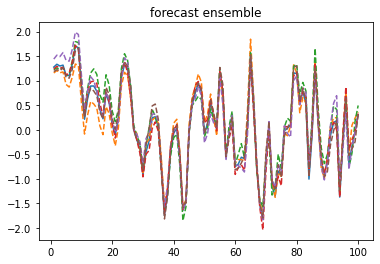

In [170]:
# forecast ensemble
## control
xfc = sPt @ rs.standard_normal(size=N)
## member
xfe = xfc[:, None] + Xf / np.sqrt(K-1)
xf = np.zeros((N,K+1))
xf[:,0] = xfc
xf[:,1:] = xfe
print(xf.shape)
initial_ctrl_err = np.sqrt(((xfc - xt)**2).mean())
print(initial_ctrl_err)
plt.plot(vindex, xf[:,0])
for k in range(1,K+1,10):
    plt.plot(vindex, xf[:,k],linestyle='dashed')
plt.title('forecast ensemble')
plt.show()

2021-09-07 08:27:33,323 anl INFO model : model
2021-09-07 08:27:33,324 anl INFO ndim=100 nmem=50
2021-09-07 08:27:33,324 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 08:27:33,325 anl INFO linf=False iloc=1 ltlm=False incremental=False
2021-09-07 08:27:33,328 anl INFO set R
2021-09-07 08:27:33,391 anl INFO ==localization==, lsig=3.0
2021-09-07 08:27:33,396 anl INFO pf eigen value = [1.13749085e+01 9.75297419e+00 6.50125970e+00 5.46919561e+00
 5.01745622e+00 4.09593837e+00 3.61198412e+00 3.52004297e+00
 3.06311837e+00 2.72169896e+00 2.55923868e+00 2.28735306e+00
 1.95755710e+00 1.93981179e+00 1.67958119e+00 1.56005529e+00
 1.46182032e+00 1.42148875e+00 1.38392015e+00 1.31143831e+00
 1.23249216e+00 1.14868031e+00 1.10803527e+00 1.09135849e+00
 1.00097089e+00 9.70888500e-01 9.23026568e-01 8.52361483e-01
 7.98712470e-01 7.30866972e-01 6.91233560e-01 6.68849113e-01
 6.59590132e-01 5.63891650e-01 5.57109691e-01 5.43753961e-01
 5.19056745e-01 5.03068951e-01 4.63148656e-


*************************************************
 N=   68

INITIAL VALUES:
 F=  1.668D+04   GNORM=  1.822D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 08:27:35,356 anl INFO minimization success
2021-09-07 08:27:35,356 anl INFO iteration = 1
2021-09-07 08:27:35,357 anl INFO final step-length = 1.0000000000000009
2021-09-07 08:27:35,357 anl INFO final function value = 76.27776427387279
2021-09-07 08:27:35,358 anl INFO final gradient norm = 6.370370278246026e-13


   1   6   7.628D+01   6.370D-13   1.0D+00   1.2D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 08:27:35,514 anl INFO eigen value =[2.57286474e-17 2.20064574e-15 9.84581006e-15 4.33480971e-14
 1.32474026e-13 3.33676176e-13 7.22525450e-13 7.10567080e-12
 2.14214457e-11 2.75619405e-11 6.44121807e-11 2.82603688e-10
 1.14674756e-09 3.08430080e-09 8.45065145e-09 2.21056574e-08
 3.97738846e-08 8.85005493e-08 1.40507972e-07 2.76177346e-07
 8.08680339e-07 1.89399523e-06 3.73590465e-06 7.73843294e-06
 1.94902125e-05 3.68894931e-05 5.67383518e-05 1.34645379e-04
 2.88284410e-04 5.68062898e-04 9.13499741e-04 1.78220946e-03
 3.02350940e-03 5.81576221e-03 1.11273633e-02 1.88920830e-02
 3.55883160e-02 5.87015409e-02 1.03684811e-01 1.62507068e-01
 2.71611705e-01 3.94874182e-01 6.22173766e-01 7.67930702e-01
 1.31302606e+00 2.06489812e+00 2.75357557e+00 3.96203060e+00
 5.03703101e+00 7.32516770e+00 1.10949920e+01 1.48010259e+01
 1.96395735e+01 2.80744889e+01 4.02274843e+01 5.56036850e+01
 7.47109916e+01 1.00278327e+02 1.40581123e+02 1.58351465e+02
 2.11763289e+02 2.71770416e+02 3.263176

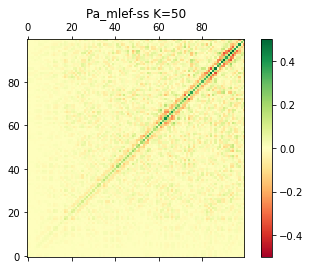

2021-09-07 08:27:35,805 anl INFO model : model
2021-09-07 08:27:35,805 anl INFO ndim=100 nmem=50
2021-09-07 08:27:35,806 anl INFO pt=mlef op=vint sig=0.125 infl_parm=1.0 lsig=3.0
2021-09-07 08:27:35,806 anl INFO linf=False iloc=1 ltlm=False incremental=False
2021-09-07 08:27:35,808 anl INFO set R
2021-09-07 08:27:35,872 anl INFO ==localization==, lsig=3.0
2021-09-07 08:27:35,876 anl INFO pf eigen value = [1.13749085e+01 9.75297419e+00 6.50125970e+00 5.46919561e+00
 5.01745622e+00 4.09593837e+00 3.61198412e+00 3.52004297e+00
 3.06311837e+00 2.72169896e+00 2.55923868e+00 2.28735306e+00
 1.95755710e+00 1.93981179e+00 1.67958119e+00 1.56005529e+00
 1.46182032e+00 1.42148875e+00 1.38392015e+00 1.31143831e+00
 1.23249216e+00 1.14868031e+00 1.10803527e+00 1.09135849e+00
 1.00097089e+00 9.70888500e-01 9.23026568e-01 8.52361483e-01
 7.98712470e-01 7.30866972e-01 6.91233560e-01 6.68849113e-01
 6.59590132e-01 5.63891650e-01 5.57109691e-01 5.43753961e-01
 5.19056745e-01 5.03068951e-01 4.63148656e-


*************************************************
 N=   68

INITIAL VALUES:
 F=  1.668D+04   GNORM=  1.822D+02
*************************************************

   I  NFN    FUNC       GNORM      STEPLEN    BETA
 ----------------------------------------------------


2021-09-07 08:27:37,814 anl INFO minimization success
2021-09-07 08:27:37,814 anl INFO iteration = 1
2021-09-07 08:27:37,815 anl INFO final step-length = 1.0000000000000009
2021-09-07 08:27:37,816 anl INFO final function value = 76.27776427387279
2021-09-07 08:27:37,816 anl INFO final gradient norm = 6.370370278246026e-13


   1   6   7.628D+01   6.370D-13   1.0D+00   1.2D-29

 SUCCESSFUL CONVERGENCE (NO ERRORS).
 IFLAG = 0


2021-09-07 08:27:37,981 anl INFO eigen value =[2.57286474e-17 2.20064574e-15 9.84581006e-15 4.33480971e-14
 1.32474026e-13 3.33676176e-13 7.22525450e-13 7.10567080e-12
 2.14214457e-11 2.75619405e-11 6.44121807e-11 2.82603688e-10
 1.14674756e-09 3.08430080e-09 8.45065145e-09 2.21056574e-08
 3.97738846e-08 8.85005493e-08 1.40507972e-07 2.76177346e-07
 8.08680339e-07 1.89399523e-06 3.73590465e-06 7.73843294e-06
 1.94902125e-05 3.68894931e-05 5.67383518e-05 1.34645379e-04
 2.88284410e-04 5.68062898e-04 9.13499741e-04 1.78220946e-03
 3.02350940e-03 5.81576221e-03 1.11273633e-02 1.88920830e-02
 3.55883160e-02 5.87015409e-02 1.03684811e-01 1.62507068e-01
 2.71611705e-01 3.94874182e-01 6.22173766e-01 7.67930702e-01
 1.31302606e+00 2.06489812e+00 2.75357557e+00 3.96203060e+00
 5.03703101e+00 7.32516770e+00 1.10949920e+01 1.48010259e+01
 1.96395735e+01 2.80744889e+01 4.02274843e+01 5.56036850e+01
 7.47109916e+01 1.00278327e+02 1.40581123e+02 1.58351465e+02
 2.11763289e+02 2.71770416e+02 3.263176

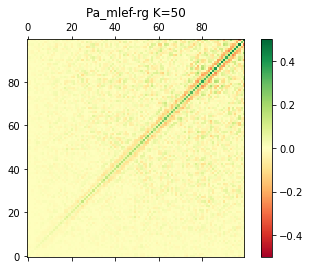

In [171]:
params = {'mlef-ss':('mlef',1,True,False),'mlef-rg':('mlef',1,False,True)}
names2 = ['mlef-ss','mlef-rg']
#names = ['mod','srf']#,'srf-ss','srf-kloc']
#Pa_app_list = [Pam]
from analysis.mlef import Mlef
from analysis.mlef_rloc import Mlef_rloc
for ptype in names2:
    pt, iloc, ss, gain = params[ptype]
    if ptype != 'mlef-rloc':
        analysis = Mlef(pt, N, K, obs, iloc=iloc, lsig=3.0, ss=ss, gain=gain, l_mat=F, l_sqrt=W, calc_dist=calc_dist, calc_dist1=calc_dist1)
    else:
        analysis = Mlef_rloc(pt, K, obs, lsig=3.0, calc_dist=calc_dist, calc_dist1=calc_dist1)
    xb = xf
    pb = Pe
    xa, Pa, sPa, innv, chi2, ds = analysis(xb, pb, y[::-1], np.arange(p-1,-1,-1))
    xa_list.append(xa[:,0])
    Pa_app_list.append(Pa)
    fig, ax = plt.subplots()
    mappable = ax.matshow(Pa, cmap=cmap, norm=Normalize(vmin=-.5, vmax=.5))
    ax.invert_yaxis()
    ax.set_title(f'Pa_{ptype} K={K}')
    fig.colorbar(mappable, ax=ax, orientation='vertical')
    if ntest == 0:
        fig.savefig(f'Paevd_{ptype}_{K}.pdf')
    plt.show()

In [172]:
method = names + names2
#print(names)
xrmse = [0.0]
mse_list = []
corr_list = []
i = 1
for xam in xa_list:
    if i < len(names):
        print(f"method:{method[i]} mean")
        xrmse.append(np.sqrt(((xam - xt)**2).mean())/initial_mean_err)
    else:
        print(f"method:{method[i]} ctrl")
        xrmse.append(np.sqrt(((xam - xt)**2).mean())/initial_ctrl_err)
    i += 1
print(method)
print(f"initial error : mean={initial_mean_err}, ctrl={initial_ctrl_err} obs error:{obs.get_sig()}")
print(xrmse)
for Pa_app in Pa_app_list:
    mse_list.append(mse(Pa_app))
    corr_list.append(corr(Pa_app))
print(mse_list)
print(corr_list)
xrmse_mean.append(xrmse)
mse_mean.append(mse_list)
corr_mean.append(corr_list)
ntest += 1

method:etkf-ss mean
method:etkf-rg mean
method:po-evd mean
method:srf-ss mean
method:srf-rg mean
method:mlef-ss ctrl
method:mlef-rg ctrl
['evd', 'etkf-ss', 'etkf-rg', 'po-evd', 'srf-ss', 'srf-rg', 'mlef-ss', 'mlef-rg']
initial error : mean=1.570855131884976, ctrl=1.679774714641414 obs error:0.125
[0.0, 0.5098424315902291, 0.5098424315902291, 0.5098424315902291, 0.5432975561578121, 0.5432975561578122, 0.3511293902316623, 0.3511293902316623]
[9.358956608773452e-05, 0.0003747231842713698, 0.00026959888535282433, 0.0002674450094800324, 0.00036888222358217145, 0.00024224325813074836, 0.0003662589503941662, 0.00023952606625512302]
[0.9533565181295163, 0.7278962540381876, 0.7481744019717788, 0.7442553389345926, 0.7392644285819645, 0.7572403025134768, 0.7444667188848718, 0.7485160658465781]


## Check results

In [173]:
method = ['evd','etkf-ss','etkf-rg','po-evd','srf-ss','srf-rg','mlef-ss','mlef-rg']
print(ntest)
print(np.array(mse_mean).shape)
rmse_m = np.array(xrmse_mean).mean(axis=0)
rmse_s = np.sqrt(((np.array(xrmse_mean) - rmse_m[None,:])**2).sum(axis=0)/(ntest-1))
mse_m = np.array(mse_mean).mean(axis=0)
mse_s = np.sqrt(((np.array(mse_mean) - mse_m[None,:])**2).sum(axis=0)/(ntest-1))
corr_m = np.array(corr_mean).mean(axis=0)
corr_s = np.sqrt(((np.array(corr_mean) - corr_m[None,:])**2).sum(axis=0)/(ntest-1))
for i in range(len(method)):
    print("{:9} {:5.3e}({:5.3e}) {:5.3e}({:5.3e}) {:5.3e}({:5.3e})"
          .format(method[i], rmse_m[i], rmse_s[i], mse_m[i], mse_s[i], corr_m[i], corr_s[i]))
#print(rmse_m)
#print(rmse_s)
#print(mse_m)
#print(mse_s)
#print(corr_m)
#print(corr_s)

10
(10, 8)
evd       0.000e+00(0.000e+00) 1.228e-04(1.712e-05) 9.417e-01(7.040e-03)
etkf-ss   4.424e-01(5.676e-02) 4.486e-04(7.280e-05) 7.195e-01(1.361e-02)
etkf-rg   4.424e-01(5.676e-02) 2.906e-04(4.163e-05) 7.513e-01(7.122e-03)
po-evd    4.424e-01(5.676e-02) 2.955e-04(3.177e-05) 7.380e-01(7.909e-03)
srf-ss    4.846e-01(8.057e-02) 4.105e-04(5.862e-05) 7.305e-01(1.508e-02)
srf-rg    4.846e-01(8.057e-02) 2.869e-04(5.872e-05) 7.480e-01(2.031e-02)
mlef-ss   4.058e-01(4.039e-02) 3.731e-04(3.495e-05) 7.351e-01(1.046e-02)
mlef-rg   4.058e-01(4.039e-02) 2.602e-04(2.973e-05) 7.514e-01(6.876e-03)


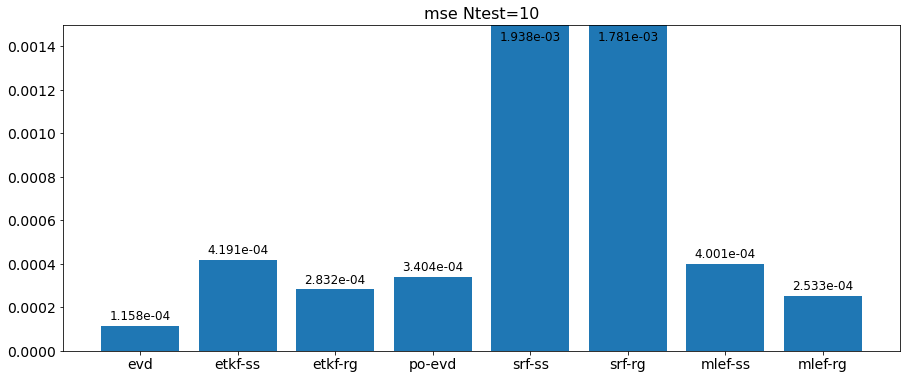

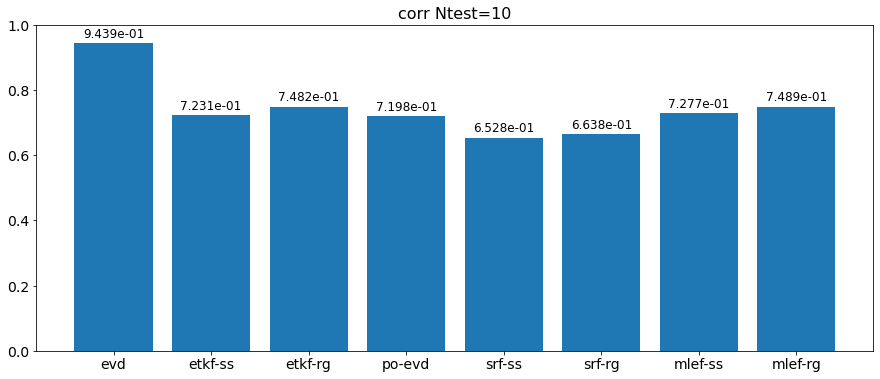

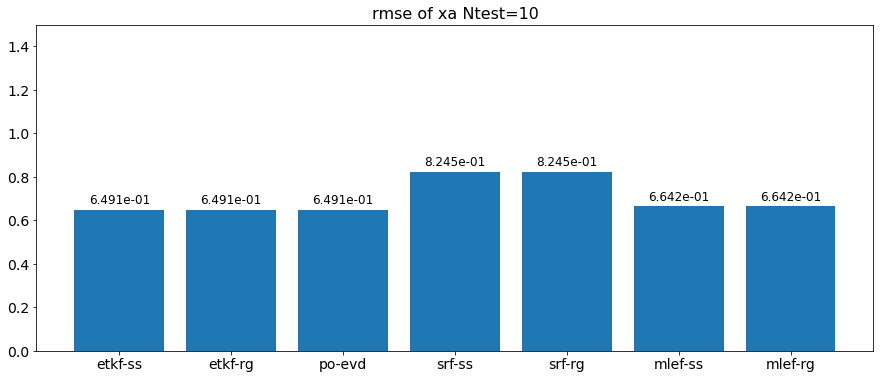

In [177]:
def autolabel(rects, set_lim=None):
    for rect in rects:
        height = rect.get_height()
        if set_lim is not None:
            height_t = min(height, set_lim)
        else:
            height_t = height
        ax.annotate('{:5.3e}'.format(height),
                   xy=(rect.get_x() + rect.get_width() / 2, height_t),
                   xytext=(0, 3),
                   textcoords='offset points',
                   ha='center', va='bottom',
                   fontsize=12)
        
#names = ['mod','ss','rg','po','kloc']
names = ['evd','etkf-ss','etkf-rg','po-evd','srf-ss','srf-rg','mlef-ss','mlef-rg']
fig, ax = plt.subplots(figsize=(15,6))
width = 0.25
xaxis = np.arange(len(Pa_app_list))
#xaxis1 = xaxis - width / 2
#xaxis2 = xaxis + width / 2
rects = ax.bar(names, mse_m)#, label="mse")
#ax.legend()
ax.set_xticks(names)
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.5e-3)
autolabel(rects, set_lim=1.4e-3)
ax.set_title(f"mse Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('mse_evd.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(15,6))
rects = ax.bar(names, corr_m)#, label="corr")
ax.set_xticks(names)
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.0)
autolabel(rects)
ax.set_title(f"corr Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('corr_evd.pdf')
plt.show()
fig, ax = plt.subplots(figsize=(15,6))
rects = ax.bar(names[1:], rmse_m)#, label="corr")
ax.set_xticks(names[1:])
ax.tick_params(labelsize = 14)
ax.set_ylim(0.0,1.5)
autolabel(rects, set_lim=1.4)
ax.set_title(f"rmse of xa Ntest={ntest}", fontdict={'fontsize':16})
fig.savefig('rmse_evd.pdf')
plt.show()

## error norm tendency

In [44]:
Nens = [10, 20, 50, 100, 200, 500, 1000]
rs = np.random.RandomState()
errd = np.zeros(len(Nens))
errnd = np.zeros(len(Nens))
nPt = Pt - np.diag(np.diag(Pt))
Ntest = 100
for j, K in zip(np.arange(errd.size),Nens):
    for i in range(Ntest):
        Xf = rs.standard_normal(size=(N,K))
        Xf = sPt @ Xf
        Xf = Xf - Xf.mean(axis=1)[:, None]
        Pe = Xf @ Xf.transpose() / (K-1)
        errnorm = norm(np.diag(Pt) - np.diag(Pe))
        #if np.mod(i, 10) == 0:
        #    print(K,i,errnorm)
        errd[j] += errnorm
        Pe -= np.diag(np.diag(Pe)) - np.diag(np.diag(Pt))
        errnorm = norm(nPt - Pe)
        errnd[j] += errnorm
errd /= Ntest
errnd /= Ntest
print(errd)
print(errnd)

[4.54666053 3.28515271 2.04974714 1.39764678 0.9893927  0.6411916
 0.45391613]
[34.50326565 25.79367496 17.59743138 14.41476607 12.36055522 10.99940219
 10.51034022]


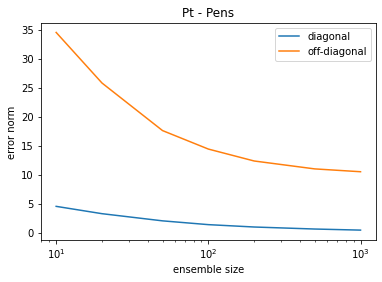

In [46]:
fig, ax = plt.subplots()
ax.plot(Nens, errd, label="diagonal")
ax.plot(Nens, errnd, label="off-diagonal")
ax.set_ylabel("error norm")
ax.set_xlabel("ensemble size")
ax.set_xscale("log")
ax.set_title("Pt - Pens")
ax.legend()
plt.show()